# **Movie Recommeded System**

**Sumber Dataset**: [Movie Lens Small Latest Dataset](https://www.kaggle.com/datasets/ayushimishra2809/movielens-dataset/data)

**Deskripsi**: Notebook ini berisi proses pembuatan sistem rekomendasi film

## **Import Library yang Dibutuhkan**

In [1]:
! pip install kaggle
! pip install opendatasets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import opendatasets as od
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Data Understanding**

Pada bagian ini, data akan dieksplor dengan tujuan untuk memahami isi, kualitas, dan penanganan data pada bagian selanjuetnya.

Dataset yang digunakan dalam proyek kali ini berjudul [Movie Lens Small Latest Dataset](https://www.kaggle.com/datasets/ayushimishra2809/movielens-dataset/data). Dataset ini berisi data rating dan free tagging (label bebas yang diberikan user kepada film) dari website [movielens.org](https://movielens.org/), sebuah layanan rekomendasi film. Untuk lebih detilnya, dataset ini berisi 105339 rating dan 10329 film. Data ini dibuat oleh 668 pengguna antara 29 Maret 1996 dan 24 September 2018.

Setelah dataset diunduh dan diekstrak, akan didapatkan file sebagai berikut.
- movies.csv
- ratings.csv

Pada proyek kali ini, file yang akan digunakan meliputi movies.csv dan ratings.csv.

### **Data Loading**

Pada bagian ini, file **movies.csv** dan **ratings.csv** akan dimuat menggunakan library pandas

In [3]:
# Mengatur config kaggle supaya bisa download langsung lewat CLI
od.download("https://www.kaggle.com/datasets/ayushimishra2809/movielens-dataset/data")

Skipping, found downloaded files in "./movielens-dataset" (use force=True to force download)


In [4]:
# Download dataset dari kaggle
# ! kaggle datasets download ayushimishra2809/movielens-dataset

In [5]:
# Unzip dataset
! unzip /content/movielens-dataset.zip

unzip:  cannot find or open /content/movielens-dataset.zip, /content/movielens-dataset.zip.zip or /content/movielens-dataset.zip.ZIP.


#### Membaca file movies.csv

In [6]:
movies_df = pd.read_csv('/content/movielens-dataset/movies.csv')
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
10324,146684,Cosmic Scrat-tastrophe (2015),Animation|Children|Comedy
10325,146878,Le Grand Restaurant (1966),Comedy
10326,148238,A Very Murray Christmas (2015),Comedy
10327,148626,The Big Short (2015),Drama


#### Membaca file ratings.csv

In [7]:
ratings_df = pd.read_csv('/content/movielens-dataset/ratings.csv')
ratings_df

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523
...,...,...,...,...
105334,668,142488,4.0,1451535844
105335,668,142507,3.5,1451535889
105336,668,143385,4.0,1446388585
105337,668,144976,2.5,1448656898


**Insight:** Dari pembacaan data di atas, diketahui bahwa jumlah data dalam movies_df adalah 10329 data dengan 3 fitur utama yaitu movieId, title, dan genres. Sedangkan data dalam rating_df berjumlah 105339 data dengan 4 fitur utama, meliputi userId, movieId, rating, dan timestamp



### **Exploratory Data Analysis**

Exploratory Data Analysis merupakan proses investigasi awal pada data untuk menganalisis karakteristik, menemukan pola, anomali, dan memeriksa asumsi pada data. Teknik ini biasanya menggunakan bantuan statistik dan representasi grafis atau visualisasi. Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

Pada proyek kali ini, proses yang akan kita lakukan meliputi:
- **Deskripsi Data**
- **Univariate Analysis**  
- **Multivariate Analaysis**  


#### **Deskripsi Data**

In [8]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10329 entries, 0 to 10328
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  10329 non-null  int64 
 1   title    10329 non-null  object
 2   genres   10329 non-null  object
dtypes: int64(1), object(2)
memory usage: 242.2+ KB


movies_df di atas berisi 9742 data film dengan 3 fitur utama, meliputi:
1. movieId (integer) -  Unique ID untuk film, contoh 1, 2, 3, dsb.
2. title (object) - judul film, contoh Toy Story
3. genre (object) - genre film, jika lebih dari satu dipisah dengan '|'. Contohnya Comedy|Romance

In [9]:
movies_df.describe(include='all')

,movieId,title,genres
count,10329.000000,10329,10329
unique,NaN,10327,938
top,NaN,War of the Worlds (2005),Drama
freq,NaN,2,1385
mean,31924.282893,NaN,NaN
std,37734.741149,NaN,NaN
min,1.000000,NaN,NaN
25%,3240.000000,NaN,NaN
50%,7088.000000,NaN,NaN
75%,59900.000000,NaN,NaN


In [10]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105339 entries, 0 to 105338
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     105339 non-null  int64  
 1   movieId    105339 non-null  int64  
 2   rating     105339 non-null  float64
 3   timestamp  105339 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.2 MB


rating_df di atas berisi 100836 data rating dengan 4 fitur utama, meliputi:
1. userId (integer) -  Unique ID untuk user, contoh 1, 2, 3, dsb.
2. movieId (integer) - Unique ID untuk film, contoh 1, 2, 3, dsb.
3. rating (float) - nilai/rating film yang diberikan oleh user, dari skala 0.5 - 5.0
4. timestamp (integer) - Waktu rating direkam (format Unix timestamp)

In [11]:
ratings_df.describe(include='all')

,userId,movieId,rating,timestamp
count,105339.000000,105339.000000,105339.000000,1.053390e+05
mean,364.924539,13381.312477,3.516850,1.130424e+09
std,197.486905,26170.456869,1.044872,1.802660e+08
min,1.000000,1.000000,0.500000,8.285650e+08
25%,192.000000,1073.000000,3.000000,9.711008e+08
50%,383.000000,2497.000000,3.500000,1.115154e+09
75%,557.000000,5991.000000,4.000000,1.275496e+09
max,668.000000,149532.000000,5.000000,1.452405e+09


**Insight**: Dataset yang digunakan dalam proyek ini memiliki dua tipe data utama, yaitu numerikal dan kategorikal. Numerikal meliputi `userId`, `movieId`, `rating`, dan `timestamp`. Kemudian untuk kategorikal meliputi `title` dan `genre`. Fitur rating dalam data di atas memiliki nilai rata-rata sebesar 3.55 dari skala 0.5 hingga 5. Nilai ini menyisyaratkan bahwa rating yang diberikan pengguna rata-rata adalah sedang/lumayan atau bisa juga karena keberagaman rating yang ada dalam data proyek ini.

#### **Univariate Analysis**

Analisis ini merupakan analisis pada tiap fitur dengan tujuan untuk mengetahui karakteristik dan struktur pada variabel

In [12]:
print('Jumlah data film dalam movie_df: ', len(movies_df.movieId.unique()))
print('Jumlah data genre film: ', len(movies_df.genres.unique()))
print('Jumlah data film yang diberi rating dalam rating_df: ', len(ratings_df.movieId.unique()))
print('Jumlah data user yang memberi rating : ', len(ratings_df.userId.unique()))
print('Jumlah data rating yang diberikan: ', len(ratings_df))

Jumlah data film dalam movie_df:  10329
Jumlah data genre film:  938
Jumlah data film yang diberi rating dalam rating_df:  10325
Jumlah data user yang memberi rating :  668
Jumlah data rating yang diberikan:  105339


Terlihat pada output di atas bahwa jumlah film unik pada movies_df dan ratings_df berbeda. Dapat disimpulkan bahwa tidak semua film dalam movies_df sudah diberi rating oleh pengguna

In [13]:
print('Genre film: ', movies_df.genres.unique())

Genre film:  ['Adventure|Animation|Children|Comedy|Fantasy'
 'Adventure|Children|Fantasy' 'Comedy|Romance' 'Comedy|Drama|Romance'
 'Comedy' 'Action|Crime|Thriller' 'Adventure|Children' 'Action'
 'Action|Adventure|Thriller' 'Comedy|Horror'
 'Adventure|Animation|Children' 'Drama' 'Action|Adventure|Romance'
 'Crime|Drama' 'Drama|Romance' 'Action|Comedy|Crime|Drama|Thriller'
 'Comedy|Crime|Thriller' 'Crime|Drama|Horror|Mystery|Thriller'
 'Drama|Sci-Fi' 'Children|Drama' 'Adventure|Drama|Fantasy|Mystery|Sci-Fi'
 'Mystery|Sci-Fi|Thriller' 'Adventure|Romance|IMAX' 'Drama|War'
 'Action|Crime|Drama' 'Action|Adventure|Fantasy' 'Comedy|Drama|Thriller'
 'Mystery|Thriller' 'Animation|Children|Drama|Musical|Romance'
 'Crime|Mystery|Thriller' 'Adventure|Drama' 'Children|Comedy'
 'Drama|Mystery' 'Drama|Thriller' 'Comedy|Crime' 'Action|Sci-Fi|Thriller'
 'Action|Comedy|Horror|Thriller' 'Comedy|Drama'
 'Action|Crime|Drama|Thriller' 'Crime|Drama|Romance'
 'Action|Adventure|Drama' 'Action|Thriller' 'Drama|H

Terlihat dari output di atas, data genre kebanyakan berisi lebih dari satu tiap datanya. Hal ini normal untuk sebuah film

In [14]:
# Melihat genre secara unique atau satuan
def genre_unique():
  genre = []
  for i in movies_df.genres.unique():
    for j in i.split('|'):
      if j not in genre:
        genre.append(j)
  return genre

print('Jumlah genre unik: ', len(genre_unique()))
print('Genre unik: ')
print(*genre_unique(), sep='\n')

Jumlah genre unik:  20
Genre unik: 
Adventure
Animation
Children
Comedy
Fantasy
Romance
Drama
Action
Crime
Thriller
Horror
Mystery
Sci-Fi
IMAX
War
Musical
Documentary
Western
Film-Noir
(no genres listed)


Dari output di atas, terlihat bahwa ada film yang genrenya tidak dicantumkan atau tidak ditulis dalam data, representasi genrenya ditulis dengan no genre list

In [15]:
movies_df[movies_df.genres == '(no genres listed)']

,movieId,title,genres
10172,126929,Li'l Quinquin ( ),(no genres listed)
10260,135460,Pablo (2012),(no genres listed)
10280,138863,The Big Broadcast of 1936 (1935),(no genres listed)
10301,141305,Round Trip to Heaven (1992),(no genres listed)
10303,141472,The 50 Year Argument (2014),(no genres listed)
10317,143709,The Take (2009),(no genres listed)
10328,149532,Marco Polo: One Hundred Eyes (2015),(no genres listed)


In [16]:
len(movies_df[movies_df.genres == '(no genres listed)'])

7

Terlihat bahwa ada 7 film yang tidak mencantumkan genrenya dalam data. Dan direpresentasikan dengan no genre list

**Cek Nilai Kosong**

In [17]:
movies_df.isnull().sum()

,0
movieId,0
title,0
genres,0


In [18]:
ratings_df.isnull().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0


**Cek Nilai Duplikat**

In [19]:
movies_df.duplicated().sum()

np.int64(0)

In [20]:
ratings_df.duplicated().sum()

np.int64(0)

**Distribusi Data**

userId
668    5678
575    2837
458    2086
232    1421
310    1287
475    1249
128    1231
224    1182
607    1176
63     1107
Name: count, dtype: int64


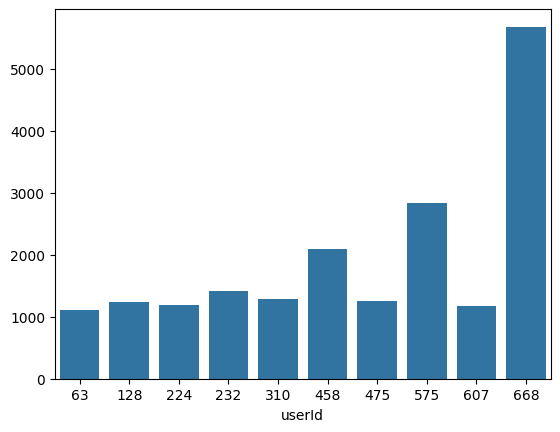

In [21]:
# 10 userId pemberi rating paling banyak
print(ratings_df.userId.value_counts().sort_values(ascending=False).head(10))
sns.barplot(x=ratings_df.userId.value_counts().sort_values(ascending=False).head(10).index, y=ratings_df.userId.value_counts().sort_values(ascending=False).head(10).values)
plt.show()

rating
4.0    28880
3.0    21729
5.0    14856
3.5    12237
4.5     8187
2.0     7943
2.5     5484
1.0     3258
1.5     1567
0.5     1198
Name: count, dtype: int64


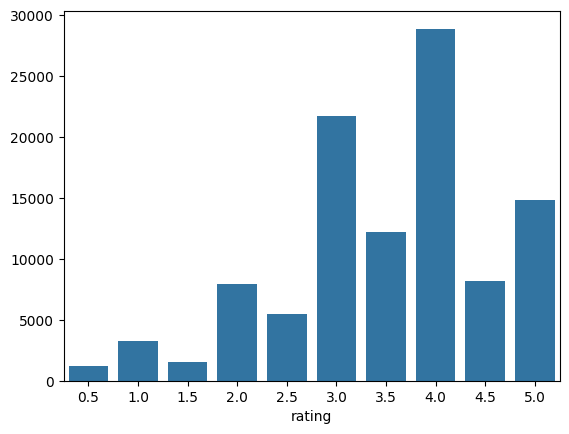

In [22]:
rating_count = ratings_df.rating.value_counts().sort_values(ascending=False)
print(rating_count)

sns.barplot(x=rating_count.index, y=rating_count.values)
plt.show()

**Insight**:
- Dataset proyek ini memiliki 10329 data film unik. Dengan 20 kategori genre unik, meliputi Action hingga Western. Selain itu, terdapat pula genre '(no genres listed)' yang menunjukkan ada beberapa film yang data genrenya kurang lengkap
- Terdapat 7 data Genre bernilai '(no genres listed)' dalam dataset. Untuk proyek ini, kita akan menggantinya menjadi satu kata untuk mengurangi term saat proses TFIDF nantinya
- Dataset pada proyek ini memiliki 668 data pengguna unik, serta 105339 data rating yang diberikan pada film
- Jumlah data film unik pada movies_df dan ratings_df berbeda. Dapat disimpulkan bahwa tidak semua film dalam movies_df sudah diberi rating oleh pengguna
- Tidak ditemukan adanya nilai kosong dan duplikat pada data, sehingga penanganan tidak diperlukan
- Melalui eksplorasi, ditemukan bahwa pengguna dengan userId 668 merupakan pengguna yang paling banyak memberikan rating pada film (2698 rating), disusur dengan userId 599(2478 rating), serta userId 474 (2108 rating)
- Rating yang diberikan pengguna dalam dataset cukup beragam dari 0.5 hingga 5.0. Rating 4.0 merupakan rating terbanyak yang diberikan pengguna pada film, sedangkan 0.5 adalah rating dengan jumlah paling sedikit yang diberikan pengguna pada film

#### **Multivariate Analysis**

Multivariate analysis adalah jenis analisis statistik atau eksplorasi data yang melibatkan tiga atau lebih variabel secara bersamaan, dengan tujuan untuk Mencari pola, hubungan, atau pengaruh antar variabel

In [23]:
# Top 10 film dengan rating terbaik
df = pd.merge(ratings_df, movies_df, on='movieId', how='left')
best_movies = df.groupby(by='title').agg({
    'rating': 'mean',
    'userId': 'count'
}).sort_values(by=['rating', 'userId'], ascending=False).head(10)
best_movies

,rating,userId
title,,
Gentlemen of Fortune (Dzhentlmeny udachi) (1972),5.0,2
Interstate 60 (2002),5.0,2
Memories (Memorîzu) (1995),5.0,2
Nobody Knows (Dare mo shiranai) (2004),5.0,2
Resident Evil: Retribution (2012),5.0,2
Schizopolis (1996),5.0,2
Wings (1927),5.0,2
21 Up (1977),5.0,1
50 Children: The Rescue Mission of Mr. And Mrs. Kraus (2013),5.0,1


In [24]:
# Top 10 paling banyak diberi rating
df = pd.merge(ratings_df, movies_df, on='movieId', how='left')
popular_movies = df.groupby(by='title').agg({
    'rating': 'mean',
    'userId': 'count'
}).sort_values(by=['userId'], ascending=False).head(10)
popular_movies

,rating,userId
title,,
Pulp Fiction (1994),4.160000,325
Forrest Gump (1994),4.138264,311
"Shawshank Redemption, The (1994)",4.454545,308
Jurassic Park (1993),3.659864,294
"Silence of the Lambs, The (1991)",4.194828,290
Star Wars: Episode IV - A New Hope (1977),4.188645,273
"Matrix, The (1999)",4.264368,261
Terminator 2: Judgment Day (1991),3.960474,253
Schindler's List (1993),4.296371,248


**Insight**:
- Melaui eksplorasi, ditemukan bahwa Gentlemen of Fortune (Dzhentlmeny udachi) (1972), Interstate 60 (2002), Memories (Memorîzu) (1995), Nobody Knows (Dare mo shiranai) (2004), Resident Evil: Retribution (2012), Schizopolis (1996), dan Wings (1927) merupakan film dengan rating terbaik (5.0) jika diurutkan berdasarkan rating dan jumlah rating. Jumlah rating yang dimiliki oleh film tersebut adalah 2, yang mana sangat sedikit
- Melalui ekplorasi, ditemukan bahwa Pulp Fiction (1994) merupakan film yang memiliki jumlah rating terbanyak yang diberikan pengguna (325 rating), disusul oleh Forrest Gump, The (1994) (311 rating), dan Shawshank Redemption, The (1994) (308 rating)

### **Data Preparation**

Setelah melalui tahapan Data Understanding dan sebelum membangun model machine learning, diperlukan tahapan data preparation untuk memastikan bahwa data dalam kondisi bersih, konsisten, dan siap untuk digunakan dalam proses pelatihan model. Pada proyek ini akan dilakukan beberapa tahapan, yaitu,
- Menghapus Fitur yang tidak Diperlukan
- Tranformasi nilai fitur genres pada dataset
- Persiapan data model Content Based Filtering
- Persiapan data model Collaborative Filtering

Pada tahapan ini pembersihan data seperti menghapus nilai kosong dan duplikat tidak dilakukan karena tidak ditemukan adanya nilai-nilai tersebut pada data

#### **Menghapus Fitur yang tidak Diperlukan**

Pada proyek kali ini, kita tidak akan menggunakan fitur atau kolom timestamp. Oleh sebab itu, kita akan menghapusnya di sini

In [25]:
ratings_df = ratings_df.drop(columns=['timestamp'])
ratings_df

,userId,movieId,rating
0,1,16,4.0
1,1,24,1.5
2,1,32,4.0
3,1,47,4.0
4,1,50,4.0
...,...,...,...
105334,668,142488,4.0
105335,668,142507,3.5
105336,668,143385,4.0
105337,668,144976,2.5


#### **Transformasi Fitur Genres**

Pada bagian ini, format nilai genre akan diubah dengan menghapus `'|'` menjadi `spasi`. Hal ini dilakukan agar nilai dari genres lebih rapi.

Pada bagian ini juga dilakukan pengubahan nilai '(no genres listed)' menjadi satu kata yaitu, '(no_genres_listed)'. Hal ini dilakukan untuk mengurangi matriks term yang dihasilkan oleh proses TFIDF nantinya

In [26]:
movies_df.genres = movies_df.genres.str.replace('|', ' ')
movies_df.genres = movies_df.genres.str.replace('(no genres listed)', '(no_genres_listed)')
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
10324,146684,Cosmic Scrat-tastrophe (2015),Animation Children Comedy
10325,146878,Le Grand Restaurant (1966),Comedy
10326,148238,A Very Murray Christmas (2015),Comedy
10327,148626,The Big Short (2015),Drama


In [27]:
print(len(movies_df[(movies_df.genres == '(no genres listed)')]))

0


In [28]:
print(len(movies_df[(movies_df.genres == '(no_genres_listed)')]))

7


Terlihat pada output di atas bahwa nilai `'|'` sudah terganti menjadi spasi dan nilai '(no genres listed)' sudah berubah menjadi satu kata

#### **Persiapan data model Content Based Filtering**

##### **Mengubah genre film menjadi vektor TF-IDF**

Pada tahap ini, kita akan menggunakan fitur genres pada movies_df

In [30]:
# Inisialisasi TfidfVectorizer
vectorizer = TfidfVectorizer(token_pattern=r'(?u)\b[\w\-]+\b')

# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = vectorizer.fit_transform(movies_df['genres'])

# Melihat ukuran matrix tfidf
print(tfidf_matrix.shape)

# Mapping array dari fitur index integer ke fitur nama
print(vectorizer.get_feature_names_out())

(10329, 20)
['action' 'adventure' 'animation' 'children' 'comedy' 'crime'
 'documentary' 'drama' 'fantasy' 'film-noir' 'horror' 'imax' 'musical'
 'mystery' 'no_genres_listed' 'romance' 'sci-fi' 'thriller' 'war'
 'western']


In [31]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0.        , 0.40410292, 0.53921623, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.50527236, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [33]:
# Membuat dataframe untuk melihat tf-idf matrix
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=vectorizer.get_feature_names_out(),
    index=movies_df.title
)

,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film-noir,horror,imax,musical,mystery,no_genres_listed,romance,sci-fi,thriller,war,western
title,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),0.0,0.404103,0.539216,0.501506,0.263837,0.0,0.0,0.00000,0.474161,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Jumanji (1995),0.0,0.505272,0.000000,0.627061,0.000000,0.0,0.0,0.00000,0.592869,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Grumpier Old Men (1995),0.0,0.000000,0.000000,0.000000,0.602350,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.798232,0.0,0.0,0.0,0.0
Waiting to Exhale (1995),0.0,0.000000,0.000000,0.000000,0.541389,0.0,0.0,0.43837,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.717446,0.0,0.0,0.0,0.0
Father of the Bride Part II (1995),0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cosmic Scrat-tastrophe (2015),0.0,0.000000,0.689338,0.641130,0.337291,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Le Grand Restaurant (1966),0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
A Very Murray Christmas (2015),0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


##### **Menghitung nilai similarity dengan cosine similarity**

In [34]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.79977247, 0.1589222 , ..., 0.2638368 , 0.        ,
        0.        ],
       [0.79977247, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.1589222 , 0.        , 1.        , ..., 0.60235038, 0.        ,
        0.        ],
       ...,
       [0.2638368 , 0.        , 0.60235038, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [35]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama resto
cosine_sim_df = pd.DataFrame(cosine_sim, index=movies_df.title, columns=movies_df.title)
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap resto
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (10329, 10329)


title,Steamboy (Suchîmubôi) (2004),Catwoman (2004),Side by Side (2012),Wall Street (1987),Harvey (1950)
title,,,,,
Friday the 13th Part 2 (1981),0.000000,0.000000,0.0,0.000000,0.000000
Anger Management (2003),0.000000,0.000000,0.0,0.000000,0.486226
Wind (1992),0.309816,0.358075,0.0,0.000000,0.000000
Redemption (Hummingbird) (2013),0.252471,0.624225,0.0,0.000000,0.000000
"Last Station, The (2009)",0.263557,0.000000,0.0,1.000000,0.000000
Barbara (2012),0.263557,0.000000,0.0,1.000000,0.000000
This Sporting Life (1963),0.263557,0.000000,0.0,1.000000,0.000000
"Onion Field, The (1979)",0.263557,0.000000,0.0,1.000000,0.000000
Act of Valor (2012),0.219894,0.254146,0.0,0.000000,0.000000


#### **Persiapan data model Collaborative Filtering**

##### **Penggabungan Data**

In [36]:
rating_movies = pd.merge(ratings_df, movies_df, on='movieId', how='left')
rating_movies.head()

,userId,movieId,rating,title,genres
0,1,16,4.0,Casino (1995),Crime Drama
1,1,24,1.5,Powder (1995),Drama Sci-Fi
2,1,32,4.0,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery Sci-Fi Thriller
3,1,47,4.0,Seven (a.k.a. Se7en) (1995),Mystery Thriller
4,1,50,4.0,"Usual Suspects, The (1995)",Crime Mystery Thriller


##### **Encoding ID Pengguna dan Film**

In [37]:
# Mengubah userId menjadi list tanpa nilai yang sama
user_ids = rating_movies['userId'].unique().tolist()
print('list userId: ', user_ids)

# Melakukan encoding userId
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userId : ', user_to_user_encoded)

# Melakukan proses encoding angka ke ke userId
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userId: ', user_encoded_to_user)

list userId:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

In [38]:
# Mengubah movieId menjadi list tanpa nilai yang sama
movie_ids = rating_movies['movieId'].unique().tolist()

# Melakukan proses encoding movieId
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}

# Melakukan proses encoding angka ke movieId
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_ids)}

In [39]:
# Mapping userID ke dataframe user
rating_movies['user'] = rating_movies['userId'].map(user_to_user_encoded)

# Mapping placeID ke dataframe resto
rating_movies['movie'] = rating_movies['movieId'].map(movie_to_movie_encoded)

##### **Pengacakan Dataset**

In [40]:
# Pengacakan dataset untuk menghindari Bias Urutan Data dan
rating_movies = rating_movies.sample(frac=1, random_state=42)
rating_movies

,userId,movieId,rating,title,genres,user,movie
41032,285,2605,3.0,Entrapment (1999),Crime Thriller,284,1575
1938,24,897,4.0,For Whom the Bell Tolls (1943),Adventure Drama Romance War,23,1118
92480,607,4016,4.0,"Emperor's New Groove, The (2000)",Adventure Animation Children Comedy Fantasy,606,318
30160,219,3981,2.0,Red Planet (2000),Action Sci-Fi Thriller,218,2522
28079,203,546,2.0,Super Mario Bros. (1993),Action Adventure Children Comedy Fantasy Sci-Fi,202,407
...,...,...,...,...,...,...,...
54886,402,780,2.5,Independence Day (a.k.a. ID4) (1996),Action Adventure Sci-Fi Thriller,401,34
76820,541,2334,4.0,"Siege, The (1998)",Action Thriller,540,2489
103694,668,55288,2.5,Reservation Road (2007),Drama Thriller,667,2733
860,11,377,3.0,Speed (1994),Action Romance Thriller,10,19


##### **Normalisasi Rating ke dalam rentang 0-1**

In [41]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)

# Mendapatkan jumlah film
num_movies = len(movie_encoded_to_movie)
print(num_movies)

# Nilai minimum rating
min_rating = min(rating_movies['rating'])

# Nilai maksimal rating
max_rating = max(rating_movies['rating'])

print('Number of User: {}, Number of movies: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_movies, min_rating, max_rating
))

668
10325
Number of User: 668, Number of movies: 10325, Min Rating: 0.5, Max Rating: 5.0


In [42]:
# Membuat variabel x untuk mencocokkan data user dan film menjadi satu value
x = rating_movies[['user', 'movie']].values

# Membuat variabel y untuk membuat rating dari hasil
y = rating_movies['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

##### **Pembagian Data Pelatihan dan Validasi**

In [43]:
# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * rating_movies.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[ 284 1575]
 [  23 1118]
 [ 606  318]
 ...
 [ 667 2733]
 [  10   19]
 [ 127 1983]] [0.55555556 0.77777778 0.77777778 ... 0.44444444 0.55555556 0.55555556]


### Modelling

Setelah melakukan Data Preparation, selanjutnya adalah melakukan modelling machine learning. Modelling dalam sistem rekomendasi adalah proses membangun metode yang dapat memberikan rekomendasi berdasarkan preferensi dan kebutuhan pengguna. Dalam kasus ini, sistem rekomendasi yang dibuat menggunakan pendekatan Content-Based Filtering berbasis similarity dan Collaborative Filtering berbasis deep learning

#### **Content-based Filtering**

Pendekatan pertama yang digunakan adalah **Content-Based Filtering**, yaitu metode yang memberikan rekomendasi berdasarkan kesamaan konten antar item. Dalam hal ini, yang digunakan sebagai fitur konten adalah *genres* dari setiap film.

**Langkah-langkah**:
- Data pada kolom `genres` diubah menjadi representasi numerik menggunakan TF-IDF.
- Kemudian dihitung *cosine similarity* antar film berdasarkan TF-IDF tersebut.
- Untuk setiap film yang pernah disukai oleh pengguna, sistem akan merekomendasikan Top-N film lain yang memiliki tingkat kemiripan tertinggi.

In [44]:
def movies_recommendations(judul_film, similarity_data=cosine_sim_df, items=movies_df[['title', 'genres']], k=10):
    """
    Rekomendasi Film berdasarkan kemiripan dataframe

    Parameter:
    ---
    judul_film : tipe data string (str)
                Judul Film (index kemiripan dataframe)
    similarity_data : tipe data pd.DataFrame (object)
                      Kesamaan dataframe, simetrik, dengan judul film sebagai
                      indeks dan kolom
    items : tipe data pd.DataFrame (object)
            Mengandung kedua nama dan fitur lainnya yang digunakan untuk mendefinisikan kemiripan
    k : tipe data integer (int)
        Banyaknya jumlah rekomendasi yang diberikan
    ---


    Pada index ini, kita mengambil k dengan nilai similarity terbesar
    pada index matrix yang diberikan (i).
    """

    if judul_film not in similarity_data.columns:
        raise ValueError(f"Judul film '{judul_film}' tidak ditemukan dalam data.")


    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,judul_film].to_numpy().argpartition(
        range(-1, -k, -1))
    # dengan menggunakan argpartition, kita mengambil sejumlah nilai k tertinggi dari similarity data (dalam kasus ini: dataframe cosine_sim_df)
    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop judul_film agar judul film yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(judul_film, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

#### **Collaborative Filtering**



Pendekatan kedua adalah **Collaborative Filtering berbasis Deep Learning**. Metode ini belajar dari interaksi antara pengguna dan item (film) dalam bentuk rating, tanpa melihat konten dari film tersebut. Model ini digunakan untuk memprediksi rating yang mungkin diberikan pengguna terhadap film yang belum pernah ditonton. Dari hasil tersebut diambil **Top-10 film rekomendasi** dengan prediksi rating tertinggi.


In [45]:
class RecommenderNet(keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_movies, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movies = num_movies
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.resto_embedding = layers.Embedding( # layer embeddings resto
        num_movies,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.movies_bias = layers.Embedding(num_movies, 1) # layer embedding resto bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    movies_vector = self.resto_embedding(inputs[:, 1]) # memanggil layer embedding 3
    movies_bias = self.movies_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_movies = tf.tensordot(user_vector, movies_vector, 2)

    x = dot_user_movies + user_bias + movies_bias

    return tf.nn.sigmoid(x) # activation sigmoid

In [46]:
model = RecommenderNet(num_users, num_movies, 50) # inisialisasi model

# model compile
model.compile(
    loss = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[keras.metrics.RootMeanSquaredError()]
)

In [47]:
# Memulai training

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 32,
    epochs = 30,
    validation_data = (x_val, y_val)
)

Epoch 1/30
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.6523 - root_mean_squared_error: 0.2514 - val_loss: 0.6128 - val_root_mean_squared_error: 0.2093
Epoch 2/30
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.6091 - root_mean_squared_error: 0.2068 - val_loss: 0.6088 - val_root_mean_squared_error: 0.2047
Epoch 3/30
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.6025 - root_mean_squared_error: 0.1994 - val_loss: 0.6058 - val_root_mean_squared_error: 0.2013
Epoch 4/30
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.6003 - root_mean_squared_error: 0.1983 - val_loss: 0.6042 - val_root_mean_squared_error: 0.1996
Epoch 5/30
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.5988 - root_mean_squared_error: 0.1961 - val_loss: 0.6033 - val_root_mean_squared_error: 0.1984
Epoch 6/30
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.5983 - root_mean_squared_error: 0.1947 - val_loss: 0.6033 - val_root_mean_squared_error: 0.1983
Epoch 7/30
2634/2634 ━━━━━━━━━━━━━━━━

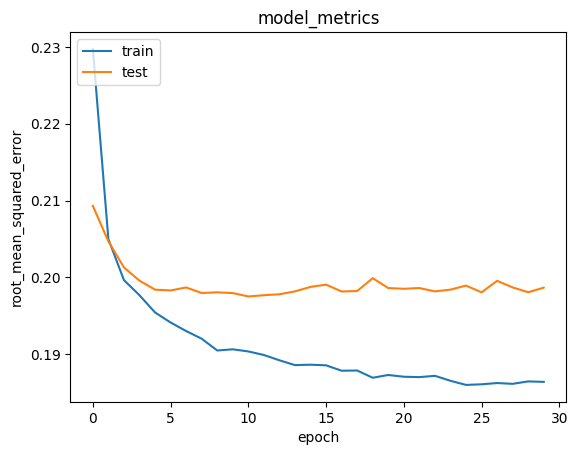

In [48]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


Dari gambar grafik pelatihan tersebut RMSE dapat diketahui beberapa poin sebagai berikut:
- RMSE data train menurun secara konsisten dari sekitar 0.23 ke sekitar 0.185, menunjukkan bahwa model berhasil belajar dengan baik pada data pelatihan.
- RMSE data test awalnya juga menurun tajam hingga sekitar epoch ke-3 atau ke-4, tetapi kemudian cenderung stagnan dan sedikit fluktuatif di kisaran 0.20.
- Gap antara RMSE train dan test mulai melebar setelah epoch ke-5, yang mengindikasikan adanya kemungkinan overfitting—model terlalu menyesuaikan diri dengan data pelatihan dan kurang generalisasi ke data test.
- Diketahui nilai `RMSE akhir` untuk data `train` sebesar `0.1866`, sedangkan `nilai RMSE` untuk data `validation` sebesar `0.2023`

### **Evaluation**

Pada bagian ini digunakan dua metrik evaluasi untuk menilai kinerja model sistem rekomendasi yang dibangun, yaitu **Root Mean Squared Error (RMSE)** dan **Precision@K**. Kedua metrik ini digunakan untuk mengukur performa model dari sisi regresi dan klasifikasi Top-N rekomendasi. RMSE untuk model Collaborative Filtering, sedangkan Precision@K untuk model Content-based Filtering

#### **Evaluasi Content-based Filtering**

In [49]:
print("Rekomendasi untuk: ")
print(movies_df[movies_df.title == 'Jumanji (1995)'].title[1])
print("genre: ", movies_df[movies_df.title == 'Jumanji (1995)'].genres[1])

# Mendapatkan rekomendasi film yang mirip Jumanji (1995)
movies_recommendations('Jumanji (1995)')

Rekomendasi untuk: 
Jumanji (1995)
genre:  Adventure Children Fantasy


,title,genres
0,"Chronicles of Narnia: The Lion, the Witch and ...",Adventure Children Fantasy
1,Return to Oz (1985),Adventure Children Fantasy
2,"Indian in the Cupboard, The (1995)",Adventure Children Fantasy
3,"Chronicles of Narnia: Prince Caspian, The (2008)",Adventure Children Fantasy
4,"Golden Compass, The (2007)",Adventure Children Fantasy
5,Darby O'Gill and the Little People (1959),Adventure Children Fantasy
6,Escape to Witch Mountain (1975),Adventure Children Fantasy
7,Magic in the Water (1995),Adventure Children Fantasy
8,"NeverEnding Story, The (1984)",Adventure Children Fantasy
9,"Water Horse: Legend of the Deep, The (2007)",Adventure Children Fantasy


Terlihat pada tabel di atas, bahwa Jumlah rekomendasi yang relevan adalah adalah 10. Oleh sebab itu, maka dapat disimpulkan `nilai precision@k untuk model ini adalah 10/10 atau 100%` (hasil dari jumlah rekomendasi yang relevan dibagi dengan total rekomendasi)

#### **Evaluation Collaborative Filtering**

In [50]:
def recommend_movies(user_id):
  movies_watched_by_user = rating_movies[rating_movies.userId == user_id]
  # Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html
  movies_not_watched = movies_df[~movies_df['movieId'].isin(movies_watched_by_user.movieId.values)]['movieId']
  movies_not_watched = list(
      set(movies_not_watched)
      .intersection(set(movie_to_movie_encoded.keys()))
  )

  movies_not_watched = [[movie_to_movie_encoded.get(x)] for x in movies_not_watched]
  user_encoder = user_to_user_encoded.get(user_id)
  user_resto_array = np.hstack(
      ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
  )
  ratings = model.predict(user_resto_array).flatten()

  top_ratings_indices = ratings.argsort()[-10:][::-1]
  recommended_movies_ids = [
      movie_encoded_to_movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
  ]

  print('Showing recommendations for users: {}'.format(user_id))
  print('===' * 9)
  print('Movies with high ratings from user')
  print('----' * 8)

  top_movies_user = (
      movies_watched_by_user.sort_values(
          by = 'rating',
          ascending=False
      )
      .head(5)
      .movieId.values
  )

  movies_df_rows = movies_df[movies_df['movieId'].isin(top_movies_user)]
  for row in movies_df_rows.itertuples():
      print(row.title, ' genre: ', row.genres)

  print('----' * 8)
  print('Top 10 movies recommendation')
  print('----' * 8)

  recommended_movies = movies_df[movies_df['movieId'].isin(recommended_movies_ids)]
  for row in recommended_movies.itertuples():
      print(row.title, ' genre: ', row.genres)

# Mengambil sample user
user_id = rating_movies.userId.sample(1).iloc[0]
recommend_movies(user_id)

292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Showing recommendations for users: 461
Movies with high ratings from user
--------------------------------
Christmas Story, A (1983)  genre:  Children Comedy
Vampire Hunter D: Bloodlust (Banpaia hantâ D) (2000)  genre:  Animation Fantasy Horror Sci-Fi
Nine Queens (Nueve reinas) (2000)  genre:  Crime Thriller
Dawn of the Dead (1978)  genre:  Action Drama Horror
Kung Fu Hustle (Gong fu) (2004)  genre:  Action Comedy
--------------------------------
Top 10 movies recommendation
--------------------------------
Notorious (1946)  genre:  Film-Noir Romance Thriller
Touch of Evil (1958)  genre:  Crime Film-Noir Thriller
Raise the Red Lantern (Da hong deng long gao gao gua) (1991)  genre:  Drama
Splendor in the Grass (1961)  genre:  Drama Romance
Samouraï, Le (Godson, The) (1967)  genre:  Crime Drama Thriller
Memories of Murder (Salinui chueok) (2003)  genre:  Crime Drama Mystery Thriller
Persepolis (2007)  genre:  Animation Drama
Dr. Horrible's Sing-Al

Dari tabel hasil rekomendasi di atas, dapat disimpulkan bahwa hasil rekomendasi cukup presisi dalam merekomendasikan film untuk userId 461. Terlihat bahwa film yang direkomendasikan setidaknya memiliki satu genre yang mirip dengan film yang diberi rating user. Rata-rata film yang direkomendasikan rilis di bawah tahun 2012.